In [1]:
!pip install transformers
!pip install peft
!pip install datasets
!pip install git+https://github.com/huggingface/accelerate.git
!pip install bitsandbytes
!pip install torch
# !pip install mlflow --ignore-installed blinker

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.7/9.7 MB 35.0 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 792.7/792.7 kB 39.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 52.1 MB/s eta 0:00:00

[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python -m pip install --upgrade pip

[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python -m pip install --upgrade pip
  Using cached aiohttp-3.11.11-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (7.7 kB)
  Using cached aiohappyeyeballs-2.4.4-py3-none-any.whl.metadata (6.1 kB)
  Using cached aiosignal-1.3.2-py2.py3-none-any.whl.metadata (3.8 kB)
  Using cached frozenlist-1.5.0-cp311-cp311-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (13 kB)
  Using cached multidict-6.1.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (5.0 kB)
  Using 

In [2]:
import torch

torch.manual_seed(42)
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("GPU is available")
    current_device = torch.cuda.current_device()
    device_name = torch.cuda.get_device_name(current_device)
    print("Current CUDA Device:", device_name)
else:
    device = torch.device("cpu")
    print("GPU not available, using CPU instead")

GPU is available
Current CUDA Device: NVIDIA L40


# Construct a dataset (No need to run this, completed and pushed to the cloud)

In [ ]:
import pandas as pd
from bs4 import BeautifulSoup

In [ ]:
columns = ['text_content', 'json_form']
df = pd.DataFrame(columns=columns)

with open ('../test/tool_functions/functions_without_error.txt', 'r') as f:
    data = f.read().split('\n')
for i in range(1, len(data), 3):
    if data[i] != '0x000':
        file_name = data[i-1][11:-3]
        with open('../output/' + file_name + '.txt') as json_form_file:
            json_form = json_form_file.read()
        with open('../free_api_docs/' + file_name, 'r', encoding='utf-8') as html_file:
            html_content = html_file.read()
        soup = BeautifulSoup(html_content, 'html.parser')
        text_content = soup.get_text(separator=' ', strip=True)
        new_row = pd.DataFrame({'text_content': [text_content], 'json_form': [json_form]})
        df = pd.concat([df, new_row], ignore_index=True)

df = df.drop_duplicates(subset=['text_content'])

df.shape

In [ ]:
def max_length(df):
    return {col: df[col].astype(str).map(len).max() for col in df.columns}

max_lengths = max_length(df)

max_lengths

In [ ]:
from huggingface_hub import notebook_login

notebook_login()

In [ ]:
from datasets import Dataset

df.reset_index(drop=True, inplace=True)     # remove default pandas index before converting
hf_dataset = Dataset.from_pandas(df)
repository_name = "doc2json"
private = True
hf_dataset.push_to_hub(repository_name, private=private)

# Prompt tuning - preparation

In [3]:
from huggingface_hub import notebook_login

notebook_login()

In [4]:
from transformers import AutoModelForCausalLM, AutoModel, AutoTokenizer, default_data_collator, get_linear_schedule_with_warmup, BitsAndBytesConfig
from peft import get_peft_config, get_peft_model, PromptTuningInit, PromptTuningConfig, TaskType, PeftType, PeftModel, PeftConfig
from datasets import load_dataset
from torch.utils.data import DataLoader
from tqdm import tqdm
import torch

In [9]:
model_name_or_path = "meta-llama/Meta-Llama-3-8B-Instruct"

quant_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_use_double_quant=True,
    bnb_4bit_compute_dtype=torch.bfloat16,
)
peft_config = PromptTuningConfig(
    task_type=TaskType.CAUSAL_LM,
    prompt_tuning_init=PromptTuningInit.TEXT,
    num_virtual_tokens=20,
    prompt_tuning_init_text="You will be given an API documentation. Extract the API endpoints and output in JSON format.",
    tokenizer_name_or_path=model_name_or_path,
)

In [ ]:
from IPython.display import display, HTML

checkpoint_name = f"doc2json_{model_name_or_path}_{peft_config.peft_type}_{peft_config.task_type}_v1.pt".replace(
    "/", "_"
)

tokenizer = AutoTokenizer.from_pretrained(model_name_or_path)

# set pad_token_id equal to the eos_token_id if not set
if tokenizer.pad_token_id is None:
    tokenizer.pad_token_id = tokenizer.eos_token_id

terminators = [
    tokenizer.eos_token_id,
    tokenizer.convert_tokens_to_ids("<|eot_id|>")
]

In [33]:
dataset_name = "[hidden]/APIdoc2json"
dataset = load_dataset(dataset_name)
example_sample = dataset['train'][166]

example_sample

{'text_content': 'PokÃ©mon TCG Developers PokÃ©mon TCG Developers JOIN THE COMMUNITY OF DEVELOPERS BUILDING WITH THE POKÃ\x89MON TCG API Next The most comprehensive dataset you can find From Base Set through Sword & Shield , the PokÃ©mon TCG API has the card data you need to build the ultimate application, whether that be mobile or web. Get access to prices, hi-res images, and more. Focus on your application and let us worry about the card data. Some features of the PokÃ©mon TCG API include: Prices by TCGplayer Hi-Res Images Detailed Search Queries Developer SDKs With a large community contributing to the project through various SDKs, development for you and your team has never been easier. In-depth details of every card All data delivered in JSON format such as types, attacks, abilities, and more. For Developers The PokÃ©mon TCG API allows developers to ingest card data programatically. The API exposes card and set details in an easy to consume format. Stay up to date with new sets, a

In [34]:
def format(example):
    input_messages = [
        {"role":"user", "content": example_sample['text_content']},
        {"role":"assistant", "content": example_sample['json_form']},
        {"role":"user", "content": example['text_content']},
    ]
    example['text_content'] = tokenizer.apply_chat_template(input_messages, tokenize=False) + "<|start_header_id|>assistant<|end_header_id|>\n\n"
    example['json_form'] += "<|eot_id|>"
    return example

dataset = dataset.map(format)
dataset = dataset.filter(lambda example, idx: idx != 166, with_indices=True)
display(HTML(dataset['train'][0]['text_content'].replace('\n', '<br>')))
display(HTML(dataset['train'][0]['json_form'].replace('\n', '<br>')))

# dataset, dataset['train'][165]

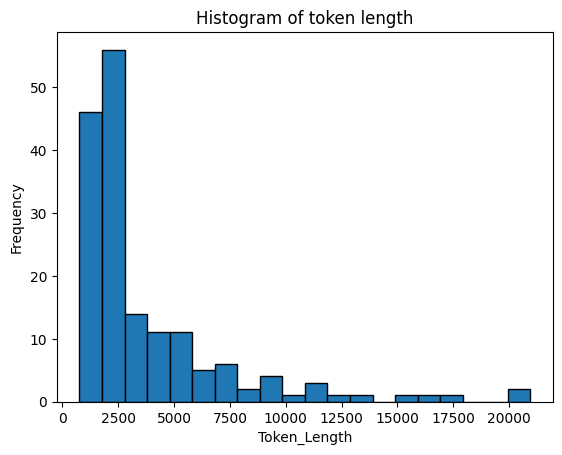

10240

In [35]:
# !pip install matplotlib
import matplotlib.pyplot as plt

def calculate_max_length(example):
    input_ids = tokenizer(example['text_content'] + example['json_form'])['input_ids']
    return {'length': len(input_ids)}

tokenized_dataset = dataset.map(calculate_max_length)
dataset_length = tokenized_dataset['train']['length']

# Find the maximum tokenized length
max_length = max(dataset_length)

# Plot the diagram for showing distribution of token length
data = tokenized_dataset['train']['length']
plt.hist(data, bins=20, edgecolor='black')
plt.title(f'Histogram of token length')
plt.xlabel('Token_Length')
plt.ylabel('Frequency')
plt.show()

max_length = 10240

max_length

In [ ]:
dataset = dataset["train"].train_test_split(test_size=0.2, seed=42)

text_column = "text_content"
label_column = "json_form"

dataset, dataset["train"][0]

In [37]:
# def preprocess_function(data):
# #     model_inputs = tokenizer(data["text_content"],
# #                              max_length=8192,
# #                              truncation=True,
# #                              padding="max_length",
# #                             )
# #     labels = tokenizer(text_target=data["json_form"],
# #                        max_length=4096,
# #                        truncation=True,
# #                        padding="max_length",
# #                       )
   
# #     model_inputs["labels"] = labels["input_ids"]
# #     return model_inputs

# # preprocessed_dataset = dataset.map(preprocess_function,fn_kwargs={"tokenizer": tokenizer})
    
   
#    message = [
#        {"role": "system", "content": ""},
#        {"role": "user", "content": data["text_content"]},
#        {"role": "assistant", "content": data["json_form"]}
#    ]
#    data["text"] = tokenizer.apply_chat_template(message, tokenize=False)
#    return data

# column_names = list(dataset["train"].features)
# preprocessed_dataset = dataset.map(preprocess_function,
#                                    remove_columns=column_names,
#                                    batched=False
#                                   )

In [ ]:
def preprocess_function(examples):
    batch_size = len(examples[text_column])
    inputs = [f"{x}" for x in examples[text_column]]
    targets = [str(x) for x in examples[label_column]]
    model_inputs = tokenizer(inputs)
    labels = tokenizer(targets)
    for i in range(batch_size):
        sample_input_ids = model_inputs["input_ids"][i]
        label_input_ids = labels["input_ids"][i] + [tokenizer.pad_token_id]
        # print(i, sample_input_ids, label_input_ids)
        model_inputs["input_ids"][i] = sample_input_ids + label_input_ids
        labels["input_ids"][i] = [-100] * len(sample_input_ids) + label_input_ids
        model_inputs["attention_mask"][i] = [1] * len(model_inputs["input_ids"][i])
    # print(model_inputs)
    for i in range(batch_size):
        sample_input_ids = model_inputs["input_ids"][i]
        label_input_ids = labels["input_ids"][i]
        model_inputs["input_ids"][i] = [tokenizer.pad_token_id] * (
            max_length - len(sample_input_ids)
        ) + sample_input_ids
        model_inputs["attention_mask"][i] = [0] * (max_length - len(sample_input_ids)) + model_inputs[
            "attention_mask"
        ][i]
        labels["input_ids"][i] = [-100] * (max_length - len(sample_input_ids)) + label_input_ids
        model_inputs["input_ids"][i] = torch.tensor(model_inputs["input_ids"][i][:max_length])
        model_inputs["attention_mask"][i] = torch.tensor(model_inputs["attention_mask"][i][:max_length])
        labels["input_ids"][i] = torch.tensor(labels["input_ids"][i][:max_length])
    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

processed_dataset = dataset.map(
    preprocess_function,
    batched=True,
    num_proc=1,
    remove_columns=dataset["train"].column_names,
    load_from_cache_file=False,
    desc="Running tokenizer on dataset",
)

In [ ]:
processed_dataset

In [40]:
train_dataset = processed_dataset["train"]
eval_dataset = processed_dataset["test"]
batch_size = 1

train_dataloader = DataLoader(
    train_dataset, shuffle=True, collate_fn=default_data_collator, batch_size=batch_size, pin_memory=True
)
eval_dataloader = DataLoader(eval_dataset, collate_fn=default_data_collator, batch_size=batch_size, pin_memory=True)

In [ ]:
train_dataset, eval_dataset

# Prompt tuning - train

In [42]:
from peft import prepare_model_for_kbit_training

model = AutoModelForCausalLM.from_pretrained(model_name_or_path, 
                                  quantization_config=quant_config,
                                 low_cpu_mem_usage=True,
                                 device_map='auto')
model = prepare_model_for_kbit_training(model)
model = get_peft_model(model, peft_config)

model.print_trainable_parameters()

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

trainable params: 81,920 || all params: 8,030,343,168 || trainable%: 0.0010


## Method 2: PyTorch

In [43]:
num_epochs = 1
lr = 1e-3

optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
lr_scheduler = get_linear_schedule_with_warmup(
    optimizer=optimizer,
    num_warmup_steps=10,
    num_training_steps=(len(train_dataloader) * num_epochs),
)

In [44]:
def get_label_idx(label_list):
    for idx, label in enumerate(label_list):
        if label != -100:
            return idx
    return len(label_list)-1

def get_label(data_point):
    idx = get_label_idx(data_point['labels'])
    label_list = data_point['input_ids'][idx:]
    return label_list

In [65]:
import mlflow
from torch.nn import NLLLoss

criterion = NLLLoss(ignore_index=-100, reduction="sum")  # For token-level prediction
train_loss_per_batch = []
eval_loss_per_batch = []
eval_epoch_loss_list = []
eval_ppl_list = []
mlflow.autolog()
for epoch in range(num_epochs):
    total_loss = 0
    total_nan = 0
    total_steps = 0
    for step, batch in enumerate(tqdm(train_dataloader)):
        total_steps += 1
        model.train()
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)     
        loss = outputs.loss
        if not torch.isnan(loss).any():
            total_loss += loss.detach().float()
        else:
            total_nan += 1
        loss.backward()
        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()

        print(loss.float())
        train_loss_per_batch.append(loss.detach().float())

        if total_steps % 20 ==0:
            model.eval()
            eval_loss = 0
            eval_preds = []
            eval_nan = 0
            total_valid_tokens = 0  # Count valid tokens for averaging loss
            total_autoregressive_loss = 0
            for step, batch in enumerate(tqdm(eval_dataloader)):
                batch = {k: v.to(device) for k, v in batch.items()}
                input_ids = batch["input_ids"]
                labels = batch["labels"]
                attention_mask = batch["attention_mask"]

                # Extract prompt tokens
                prompt_mask = labels == -100
                prompt_ids = torch.masked_select(input_ids, prompt_mask).view(input_ids.size(0), -1)

                # Autoregressive generation with logits retrieval
                with torch.no_grad():
                    generated_outputs = model.generate(
                        input_ids=prompt_ids,
                        attention_mask=attention_mask[:, :prompt_ids.size(1)],
                        max_length=labels.size(1),
                        pad_token_id=tokenizer.pad_token_id,
                        return_dict_in_generate=True,
                        output_scores=True
                    )
                    
                    generated_ids = generated_outputs.sequences
                    logits_per_step = generated_outputs.scores  # List of logits for each step

                    # Calculate autoregressive loss for each step
                    for t, step_logits in enumerate(logits_per_step):
                        target_token = labels[:, prompt_ids.size(1) + t]  # Ground truth token for step `t`
                        step_loss = criterion(
                            step_logits.log_softmax(dim=-1),  # Apply log_softmax for NLLLoss
                            target_token
                        )
                        total_autoregressive_loss += step_loss.item()
                        total_valid_tokens += (target_token != -100).sum().item()
                        
                # Decode predictions for logging
                decoded_preds = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)
                eval_preds.extend(decoded_preds)

            # Calculate average loss and perplexity
            avg_eval_loss = total_autoregressive_loss / total_valid_tokens
            eval_ppl = torch.exp(torch.tensor(avg_eval_loss))
            eval_loss_per_batch.append(avg_eval_loss)

            print(f"Eval Loss: {avg_eval_loss:.4f}, Eval PPL: {eval_ppl:.4f}")
            with open(f'eval_preds_{total_steps}_autoregressive.txt', 'w') as f:
                for item in eval_preds:
                    f.write("%s\n\n" % item)
    train_epoch_loss = total_loss / (len(train_dataloader) - total_nan)
    train_ppl = torch.exp(train_epoch_loss)
    print(f"{epoch=}: {train_ppl=} {train_epoch_loss=} {eval_ppl=} {}")
    print("train_nan: " + str(total_nan))
    print("eval_nan: " + str(eval_nan))

2025/01/08 00:27:41 WARNING mlflow.utils.autologging_utils: MLflow sklearn autologging is known to be compatible with 0.24.1 <= scikit-learn <= 1.5.2, but the installed version is 1.6.0. If you encounter errors during autologging, try upgrading / downgrading scikit-learn to a compatible version, or try upgrading MLflow.
2025/01/08 00:27:41 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2025/01/08 00:27:41 WARNING mlflow.utils.autologging_utils: MLflow transformers autologging is known to be compatible with 4.25.1 <= transformers <= 4.46.3, but the installed version is 4.47.1. If you encounter errors during autologging, try upgrading / downgrading transformers to a compatible version, or try upgrading MLflow.
2025/01/08 00:27:41 INFO mlflow.tracking.fluent: Autologging successfully enabled for transformers.
  0%|          | 0/149 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/_dynamo/eval_frame.py:600: UserWarning: torch.utils.checkpoint: the u

tensor(0.8127, device='cuda:0', grad_fn=<NllLossBackward0>)


  1%|▏         | 2/149 [01:02<1:16:30, 31.22s/it]

tensor(0.2811, device='cuda:0', grad_fn=<NllLossBackward0>)


  2%|▏         | 3/149 [01:33<1:15:50, 31.17s/it]

tensor(0.5160, device='cuda:0', grad_fn=<NllLossBackward0>)


  3%|▎         | 4/149 [02:04<1:15:20, 31.18s/it]

tensor(0.8219, device='cuda:0', grad_fn=<NllLossBackward0>)


  3%|▎         | 5/149 [02:35<1:14:54, 31.21s/it]

tensor(0.4953, device='cuda:0', grad_fn=<NllLossBackward0>)


  4%|▍         | 6/149 [03:06<1:14:24, 31.22s/it]

tensor(0.3186, device='cuda:0', grad_fn=<NllLossBackward0>)


  5%|▍         | 7/149 [03:38<1:13:56, 31.24s/it]

tensor(0.6479, device='cuda:0', grad_fn=<NllLossBackward0>)


  5%|▌         | 8/149 [04:10<1:13:54, 31.45s/it]

tensor(0.1739, device='cuda:0', grad_fn=<NllLossBackward0>)


  6%|▌         | 9/149 [04:41<1:13:15, 31.40s/it]

tensor(0.6847, device='cuda:0', grad_fn=<NllLossBackward0>)


  7%|▋         | 10/149 [05:13<1:13:11, 31.59s/it]

tensor(0.2730, device='cuda:0', grad_fn=<NllLossBackward0>)


  7%|▋         | 11/149 [05:44<1:12:24, 31.48s/it]

tensor(0.2705, device='cuda:0', grad_fn=<NllLossBackward0>)


  8%|▊         | 12/149 [06:15<1:11:45, 31.43s/it]

tensor(0.2798, device='cuda:0', grad_fn=<NllLossBackward0>)


  9%|▊         | 13/149 [06:47<1:11:11, 31.41s/it]

tensor(0.2967, device='cuda:0', grad_fn=<NllLossBackward0>)


  9%|▉         | 14/149 [07:18<1:10:36, 31.38s/it]

tensor(0.0533, device='cuda:0', grad_fn=<NllLossBackward0>)


 10%|█         | 15/149 [07:43<1:05:33, 29.36s/it]

tensor(nan, device='cuda:0', grad_fn=<NllLossBackward0>)


 11%|█         | 16/149 [08:15<1:06:50, 30.15s/it]

tensor(0.2111, device='cuda:0', grad_fn=<NllLossBackward0>)


 11%|█▏        | 17/149 [08:46<1:07:07, 30.51s/it]

tensor(0.1590, device='cuda:0', grad_fn=<NllLossBackward0>)


 12%|█▏        | 18/149 [09:18<1:07:12, 30.78s/it]

tensor(0.3074, device='cuda:0', grad_fn=<NllLossBackward0>)


 13%|█▎        | 19/149 [09:49<1:06:56, 30.89s/it]

tensor(0.5718, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.3458, device='cuda:0', grad_fn=<NllLossBackward0>)



  0%|          | 0/17 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/peft/peft_model.py:1889: UserWarning: Position ids are not supported for parameter efficient tuning. Ignoring position ids.
  warnings.warn("Position ids are not supported for parameter efficient tuning. Ignoring position ids.")

 13%|█▎        | 20/149 [17:29<5:43:42, 159.87s/it]

Eval Loss: inf, Eval PPL: inf


 14%|█▍        | 21/149 [18:00<4:18:40, 121.26s/it]

tensor(0.4724, device='cuda:0', grad_fn=<NllLossBackward0>)


 15%|█▍        | 22/149 [18:32<3:19:27, 94.24s/it] 

tensor(0.2825, device='cuda:0', grad_fn=<NllLossBackward0>)


 15%|█▌        | 23/149 [19:03<2:38:11, 75.33s/it]

tensor(0.1931, device='cuda:0', grad_fn=<NllLossBackward0>)


 16%|█▌        | 24/149 [19:34<2:09:28, 62.15s/it]

tensor(0.1318, device='cuda:0', grad_fn=<NllLossBackward0>)


 17%|█▋        | 25/149 [20:06<1:49:14, 52.86s/it]

tensor(0.3621, device='cuda:0', grad_fn=<NllLossBackward0>)


 17%|█▋        | 26/149 [20:39<1:36:20, 47.00s/it]

tensor(0.3106, device='cuda:0', grad_fn=<NllLossBackward0>)


 18%|█▊        | 27/149 [21:10<1:25:56, 42.27s/it]

tensor(0.2925, device='cuda:0', grad_fn=<NllLossBackward0>)


 19%|█▉        | 28/149 [21:41<1:18:26, 38.89s/it]

tensor(0.3273, device='cuda:0', grad_fn=<NllLossBackward0>)


 19%|█▉        | 29/149 [22:12<1:13:03, 36.53s/it]

tensor(0.2516, device='cuda:0', grad_fn=<NllLossBackward0>)


 20%|██        | 30/149 [22:43<1:09:18, 34.94s/it]

tensor(0.2018, device='cuda:0', grad_fn=<NllLossBackward0>)


 21%|██        | 31/149 [23:16<1:07:24, 34.28s/it]

tensor(0.0914, device='cuda:0', grad_fn=<NllLossBackward0>)


 21%|██▏       | 32/149 [23:41<1:01:16, 31.42s/it]

tensor(nan, device='cuda:0', grad_fn=<NllLossBackward0>)



 67%|██████▋   | 100/149 [1:32:38<2:51:22, 209.85s/it]

Eval Loss: inf, Eval PPL: inf


 68%|██████▊   | 101/149 [1:33:09<2:05:01, 156.28s/it]

tensor(0.0547, device='cuda:0', grad_fn=<NllLossBackward0>)


 68%|██████▊   | 102/149 [1:33:40<1:33:01, 118.75s/it]

tensor(0.2114, device='cuda:0', grad_fn=<NllLossBackward0>)


 69%|██████▉   | 103/149 [1:34:11<1:10:54, 92.49s/it] 

tensor(0.0772, device='cuda:0', grad_fn=<NllLossBackward0>)


 70%|██████▉   | 104/149 [1:34:45<56:04, 74.76s/it]  

tensor(0.6205, device='cuda:0', grad_fn=<NllLossBackward0>)


 70%|███████   | 105/149 [1:35:17<45:26, 61.97s/it]

tensor(0.0535, device='cuda:0', grad_fn=<NllLossBackward0>)


 71%|███████   | 106/149 [1:35:43<36:46, 51.31s/it]

tensor(4.3824, device='cuda:0', grad_fn=<NllLossBackward0>)


 72%|███████▏  | 107/149 [1:36:15<31:48, 45.45s/it]

tensor(0.1009, device='cuda:0', grad_fn=<NllLossBackward0>)


 72%|███████▏  | 108/149 [1:36:46<28:09, 41.20s/it]

tensor(0.1507, device='cuda:0', grad_fn=<NllLossBackward0>)


 73%|███████▎  | 109/149 [1:37:18<25:28, 38.21s/it]

tensor(0.2013, device='cuda:0', grad_fn=<NllLossBackward0>)


 74%|███████▍  | 110/149 [1:37:51<23:55, 36.81s/it]

tensor(0.5136, device='cuda:0', grad_fn=<NllLossBackward0>)


 74%|███████▍  | 111/149 [1:38:22<22:13, 35.10s/it]

tensor(0.3878, device='cuda:0', grad_fn=<NllLossBackward0>)


 75%|███████▌  | 112/149 [1:38:53<20:56, 33.97s/it]

tensor(0.0956, device='cuda:0', grad_fn=<NllLossBackward0>)


 76%|███████▌  | 113/149 [1:39:25<19:52, 33.12s/it]

tensor(0.2405, device='cuda:0', grad_fn=<NllLossBackward0>)


 77%|███████▋  | 114/149 [1:39:51<18:09, 31.14s/it]

tensor(5.6869, device='cuda:0', grad_fn=<NllLossBackward0>)


 77%|███████▋  | 115/149 [1:40:22<17:39, 31.15s/it]

tensor(0.2893, device='cuda:0', grad_fn=<NllLossBackward0>)


 78%|███████▊  | 116/149 [1:40:54<17:08, 31.17s/it]

tensor(0.2400, device='cuda:0', grad_fn=<NllLossBackward0>)


 79%|███████▊  | 117/149 [1:41:25<16:44, 31.40s/it]

tensor(0.1347, device='cuda:0', grad_fn=<NllLossBackward0>)


 79%|███████▉  | 118/149 [1:41:50<15:11, 29.40s/it]

tensor(nan, device='cuda:0', grad_fn=<NllLossBackward0>)


 80%|███████▉  | 119/149 [1:42:21<14:57, 29.90s/it]

tensor(0.3615, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.3209, device='cuda:0', grad_fn=<NllLossBackward0>)



 81%|████████  | 120/149 [1:54:55<1:59:22, 246.97s/it]

Eval Loss: inf, Eval PPL: inf


 81%|████████  | 121/149 [1:55:26<1:25:01, 182.19s/it]

tensor(0.2051, device='cuda:0', grad_fn=<NllLossBackward0>)


 82%|████████▏ | 122/149 [1:55:57<1:01:38, 136.97s/it]

tensor(0.0710, device='cuda:0', grad_fn=<NllLossBackward0>)


 83%|████████▎ | 123/149 [1:56:28<45:34, 105.18s/it]  

tensor(0.2899, device='cuda:0', grad_fn=<NllLossBackward0>)


 83%|████████▎ | 124/149 [1:57:01<34:44, 83.39s/it] 

tensor(0.1561, device='cuda:0', grad_fn=<NllLossBackward0>)


 84%|████████▍ | 125/149 [1:57:33<27:11, 67.97s/it]

tensor(0.0655, device='cuda:0', grad_fn=<NllLossBackward0>)


 85%|████████▍ | 126/149 [1:58:04<21:49, 56.95s/it]

tensor(0.1647, device='cuda:0', grad_fn=<NllLossBackward0>)


 85%|████████▌ | 127/149 [1:58:36<18:07, 49.45s/it]

tensor(0.0862, device='cuda:0', grad_fn=<NllLossBackward0>)


 86%|████████▌ | 128/149 [1:59:07<15:23, 43.99s/it]

tensor(0.1372, device='cuda:0', grad_fn=<NllLossBackward0>)


 87%|████████▋ | 129/149 [1:59:40<13:31, 40.57s/it]

tensor(0.1342, device='cuda:0', grad_fn=<NllLossBackward0>)


 87%|████████▋ | 130/149 [2:00:13<12:08, 38.35s/it]

tensor(0.2344, device='cuda:0', grad_fn=<NllLossBackward0>)


 88%|████████▊ | 131/149 [2:00:44<10:51, 36.21s/it]

tensor(0.1579, device='cuda:0', grad_fn=<NllLossBackward0>)


 89%|████████▊ | 132/149 [2:01:15<09:50, 34.72s/it]

tensor(0.0865, device='cuda:0', grad_fn=<NllLossBackward0>)


 89%|████████▉ | 133/149 [2:01:47<08:58, 33.65s/it]

tensor(0.0749, device='cuda:0', grad_fn=<NllLossBackward0>)


 90%|████████▉ | 134/149 [2:02:19<08:17, 33.20s/it]

tensor(0.2959, device='cuda:0', grad_fn=<NllLossBackward0>)


 91%|█████████ | 135/149 [2:02:51<07:42, 33.03s/it]

tensor(0.1322, device='cuda:0', grad_fn=<NllLossBackward0>)


 91%|█████████▏| 136/149 [2:03:23<07:02, 32.48s/it]

tensor(0.0860, device='cuda:0', grad_fn=<NllLossBackward0>)


 92%|█████████▏| 137/149 [2:03:54<06:25, 32.10s/it]

tensor(0.2938, device='cuda:0', grad_fn=<NllLossBackward0>)


 93%|█████████▎| 138/149 [2:04:25<05:50, 31.86s/it]

tensor(0.0443, device='cuda:0', grad_fn=<NllLossBackward0>)


 93%|█████████▎| 139/149 [2:04:56<05:16, 31.64s/it]

tensor(0.1818, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.1219, device='cuda:0', grad_fn=<NllLossBackward0>)



 94%|█████████▍| 140/149 [2:16:14<33:50, 225.62s/it]

Eval Loss: inf, Eval PPL: inf


 95%|█████████▍| 141/149 [2:16:46<22:18, 167.28s/it]

tensor(0.2204, device='cuda:0', grad_fn=<NllLossBackward0>)


 95%|█████████▌| 142/149 [2:17:17<14:45, 126.43s/it]

tensor(0.2279, device='cuda:0', grad_fn=<NllLossBackward0>)


 96%|█████████▌| 143/149 [2:17:48<09:46, 97.83s/it] 

tensor(0.1431, device='cuda:0', grad_fn=<NllLossBackward0>)


 97%|█████████▋| 144/149 [2:18:19<06:29, 77.97s/it]

tensor(0.2121, device='cuda:0', grad_fn=<NllLossBackward0>)


 97%|█████████▋| 145/149 [2:18:51<04:16, 64.09s/it]

tensor(0.0476, device='cuda:0', grad_fn=<NllLossBackward0>)


 98%|█████████▊| 146/149 [2:19:22<02:42, 54.21s/it]

tensor(0.2189, device='cuda:0', grad_fn=<NllLossBackward0>)


 99%|█████████▊| 147/149 [2:19:55<01:35, 47.71s/it]

tensor(1.2990, device='cuda:0', grad_fn=<NllLossBackward0>)


 99%|█████████▉| 148/149 [2:20:26<00:42, 42.78s/it]

tensor(0.1521, device='cuda:0', grad_fn=<NllLossBackward0>)


100%|██████████| 149/149 [2:20:58<00:00, 56.77s/it]

tensor(0.5822, device='cuda:0', grad_fn=<NllLossBackward0>)


NameError: name 'eval_epoch_loss' is not defined

In [ ]:
# !mlflow ui --host 0.0.0.0 --port 5000

In [66]:
import pickle
data = {'train_loss':train_loss_per_batch, 'eval_loss':eval_epoch_loss_list}
with open('training_record_autoregressive.pkl','wb') as f:
    pickle.dump(data, f)

/usr/local/lib/python3.11/dist-packages/scipy/stats/_stats_py.py:1126: RuntimeWarning: invalid value encountered in subtract
  a_zero_mean = a - mean


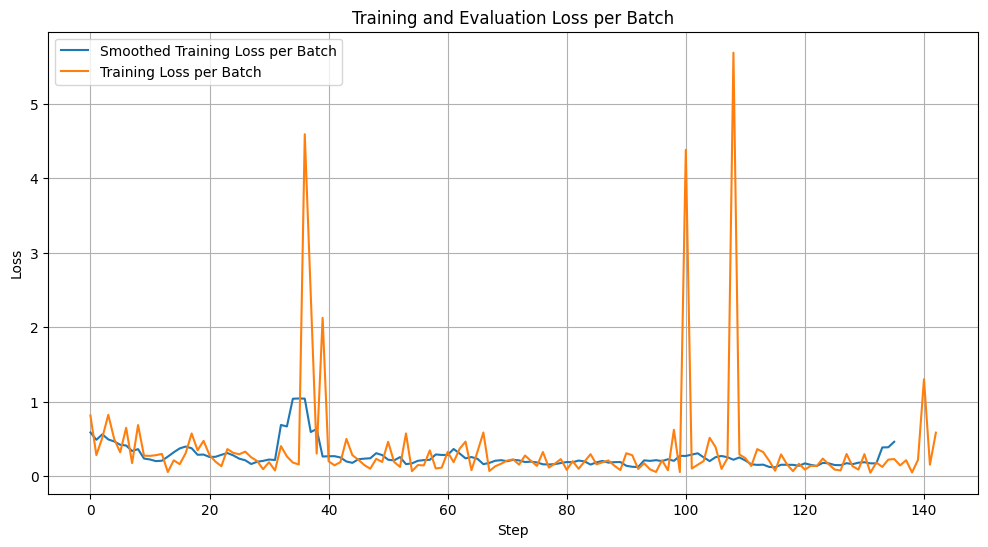

In [72]:
import matplotlib.pyplot as plt
import numpy as np

batch_losses = [x.cpu().numpy() for x in train_loss_per_batch if not torch.isnan(x)]
# batch_eval_losses = [x.cpu().numpy() for x in eval_loss_per_batch if not torch.isnan(x)]
batch_eval_losses = eval_loss_per_batch
eval_epoch_losses = [x.cpu().numpy() for x in eval_epoch_loss_list if not torch.isnan(x)]
eval_step_idxs = [20*(i+1) for i in range(len(eval_epoch_losses))]

from scipy.stats import zscore
import numpy as np

def remove_outliers_zscore(data, threshold=3):
    z_scores = zscore(data)
    return np.array([x for x, z in zip(data, z_scores) if abs(z) < threshold])

def moving_average(data, window_size=5):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')
# Remove outliers from your data
cleaned_training_loss = remove_outliers_zscore(batch_losses)
cleaned_eval_loss = remove_outliers_zscore(batch_eval_losses)

# Then apply smoothing
smoothed_training_loss = moving_average(cleaned_training_loss, window_size=5)
# smoothed_eval_loss = moving_average(cleaned_eval_loss, window_size=5)

plt.figure(figsize=(12, 6))
plt.plot(smoothed_training_loss, label='Smoothed Training Loss per Batch')
plt.plot(batch_losses, label="Training Loss per Batch")
# plt.plot(eval_step_idxs, batch_eval_loss, label="Validation Loss")
plt.title('Training and Evaluation Loss per Batch')
plt.xlabel('Step')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [73]:
with open('eval_preds_llama3_autoregressive.txt', 'w') as f:
    for item in eval_preds:
        f.write("%s\n\n" % item)

# Push to the cloud

In [18]:
peft_model_id = "[masked]/APILlama"
model.push_to_hub(peft_model_id, use_auth_token=True, private=True)

/usr/local/lib/python3.11/dist-packages/transformers/utils/hub.py:875: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers. Please use `token` instead.
  warnings.warn(


adapter_model.safetensors:   0%|          | 0.00/328k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/billyfin/APILlama_v2/commit/a1760de2b2545baae91762e364379f6a684ad7f8', commit_message='Upload model', commit_description='', oid='a1760de2b2545baae91762e364379f6a684ad7f8', pr_url=None, pr_revision=None, pr_num=None)

# Load the model

In [3]:
from peft import PeftModel, PeftConfig
from huggingface_hub import notebook_login
from transformers import AutoModelForCausalLM, AutoModel, AutoTokenizer, default_data_collator, get_linear_schedule_with_warmup, BitsAndBytesConfig
from peft import get_peft_config, get_peft_model, PromptTuningInit, PromptTuningConfig, TaskType, PeftType
from datasets import load_dataset
from torch.utils.data import DataLoader
from tqdm import tqdm
import torch

notebook_login()

In [4]:
quant_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_use_double_quant=True,
    bnb_4bit_compute_dtype=torch.bfloat16,
)

peft_model_id = "[masked]/APILlama"

config = PeftConfig.from_pretrained(peft_model_id)
model = AutoModelForCausalLM.from_pretrained(config.base_model_name_or_path,
                                             quantization_config=quant_config,
                                             low_cpu_mem_usage=True,
                                            )
model = PeftModel.from_pretrained(model, peft_model_id)

model.safetensors.index.json:   0%|          | 0.00/23.9k [00:00<?, ?B/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/4.92G [00:00<?, ?B/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/1.17G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/187 [00:00<?, ?B/s]

adapter_model.safetensors:   0%|          | 0.00/328k [00:00<?, ?B/s]

# Test & Inference

In [27]:
test_sample = dataset['test']['text_content'][3]

print(test_sample)

<|begin_of_text|><|start_header_id|>user<|end_header_id|>

PokÃ©mon TCG Developers PokÃ©mon TCG Developers JOIN THE COMMUNITY OF DEVELOPERS BUILDING WITH THE POKÃMON TCG API Next The most comprehensive dataset you can find From Base Set through Sword & Shield , the PokÃ©mon TCG API has the card data you need to build the ultimate application, whether that be mobile or web. Get access to prices, hi-res images, and more. Focus on your application and let us worry about the card data. Some features of the PokÃ©mon TCG API include: Prices by TCGplayer Hi-Res Images Detailed Search Queries Developer SDKs With a large community contributing to the project through various SDKs, development for you and your team has never been easier. In-depth details of every card All data delivered in JSON format such as types, attacks, abilities, and more. For Developers The PokÃ©mon TCG API allows developers to ingest card data programatically. The API exposes card and set details in an easy to consume fo

In [28]:
def preprocess_for_inference(examples):
    inputs = f"{examples}"
    
    model_inputs = tokenizer(inputs)
    model_inputs['input_ids'] += [tokenizer.pad_token_id]
    model_inputs["attention_mask"] = [1] * len(model_inputs["input_ids"])
    
    sample_input_ids = model_inputs["input_ids"]
    model_inputs["input_ids"] = [tokenizer.pad_token_id] * (
        max_length - len(sample_input_ids)
    ) + sample_input_ids
    model_inputs["attention_mask"] = [0] * (max_length - len(sample_input_ids)) + model_inputs[
        "attention_mask"
    ]
    model_inputs["input_ids"] = torch.tensor(model_inputs["input_ids"][:max_length])
    model_inputs["attention_mask"] = torch.tensor(model_inputs["attention_mask"][:max_length])
    return model_inputs

test_input = preprocess_for_inference(test_sample)

test_input['input_ids'].shape, test_input['attention_mask'].shape

(torch.Size([10240]), torch.Size([10240]))

In [29]:
model.train()

inputs = {k: v.unsqueeze(0).to(device) for k, v in test_input.items()}
prompt = inputs['input_ids'].shape[1]
with torch.no_grad():
    outputs = model.generate(
        input_ids=inputs["input_ids"], 
        attention_mask=inputs["attention_mask"],
        max_new_tokens=1024,
        temperature=0.1
    )

print(tokenizer.decode(outputs[0, prompt:], skip_special_tokens=True))

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
/usr/local/lib/python3.11/dist-packages/peft/peft_model.py:1889: UserWarning: Position ids are not supported for parameter efficient tuning. Ignoring position ids.
  warnings.warn("Position ids are not supported for parameter efficient tuning. Ignoring position ids.")
This is a friendly reminder - the current text generation call will exceed the model's predefined maximum length (8192). Depending on the model, you may observe exceptions, performance degradation, or nothing at all.


{
    "title": "TacoFancy API Documentation",
    "endpoints": [
        {
            "name": "Get Random Taco",
            "description": "Returns a random taco recipe.",
            "method": "GET",
            "url": "http://taco-randomizer.herokuapp.com/",
            "headers": [
                {
                    "name": "CORS",
                    "type": "string",
                    "description": "Cross-origin resource sharing header.",
                    "default": "false",
                    "example": "true"
                }
            ],
            "required_parameters": [],
            "optional_parameters": []
        },
        {
            "name": "Get Random Base Layer",
            "description": "Returns a random base layer for a taco recipe.",
            "method": "GET",
            "url": "http://taco-randomizer.herokuapp.com/random",
            "headers": [
                {
                    "name": "CORS",
                    "type": "string",
 

In [26]:
print(dataset['test']['json_form'][3])

{
    "title": "TacoFancy API Documentation",
    "endpoints": [
        {
            "name": "Get Random Taco",
            "description": "Retrieves a random taco recipe including Base Layer, Mixin, Condiment, Seasoning, and Shell.",
            "method": "GET",
            "url": "http://taco-randomizer.herokuapp.com/random/",
            "headers": [],
            "required_parameters": [],
            "optional_parameters": [
                {
                    "name": "full-taco",
                    "type": "boolean",
                    "description": "If set to true, returns a full taco recipe.",
                    "default": false,
                    "example": true
                }
            ]
        },
        {
            "name": "Get Contributors for Recipe",
            "description": "Retrieves information about the contributors for a specific recipe.",
            "method": "GET",
            "url": "http://taco-randomizer.herokuapp.com/contributors/:recipe_t